# Vibration Environment

For the first time we were able to record high fidelity and high time resolution IMU data from our rocket using the [ADIS16405](http://www.analog.com/en/mems-sensors/mems-inertial-sensors/adis16405/products/product.html) MEMS IMU.

## Acceleration Data

Lets look at the raw accel data:

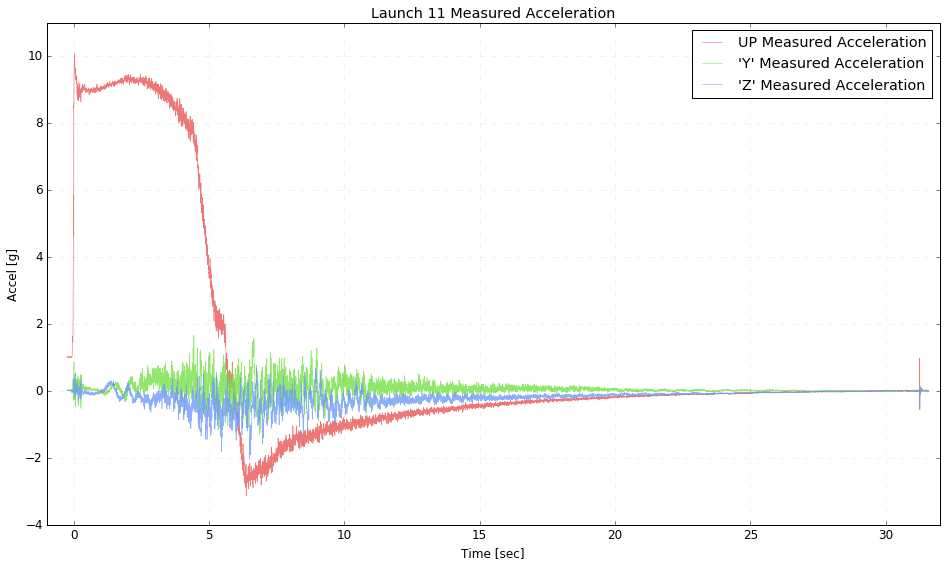

In [1]:
%matplotlib inline
import numpy
from scipy.signal import periodogram, welch
import utils
from matplotlib import rcParams
rcParams.update({'font.size': 12})
t_0 = 202945201730391 # nanoseconds in FC time frame

# Load data
columns = numpy.loadtxt("fcf/ADIS.csv", delimiter=',', unpack=True)
seqn  = columns[0]
time  = columns[1]
acc_x = columns[6]
acc_y = columns[7]
acc_z = columns[8]

time = numpy.subtract(time, t_0)
time = numpy.divide(time, 1e9)

# Units in g
acc_x = numpy.divide(acc_x, utils.g_0)
acc_y = numpy.divide(acc_y, utils.g_0)
acc_z = numpy.divide(acc_z, utils.g_0)

fig = utils.Plot("Launch 11 Measured Acceleration", "Time [sec]", "Accel [g]")
fig.plot(time[2000:28000], acc_x[2000:28000], color=utils.red, alpha=0.6, label="UP Measured Acceleration")
fig.plot(time[2000:28000], acc_y[2000:28000], color=utils.green, label="'Y' Measured Acceleration")
fig.plot(time[2000:28000], acc_z[2000:28000], color=utils.blue, label="'Z' Measured Acceleration")
fig.xlim([-1, 32])
fig.ylim([-4, 11])
fig.legend()
fig.show()

## Periodogram

Of the whole dataset in the 'Y' axis:

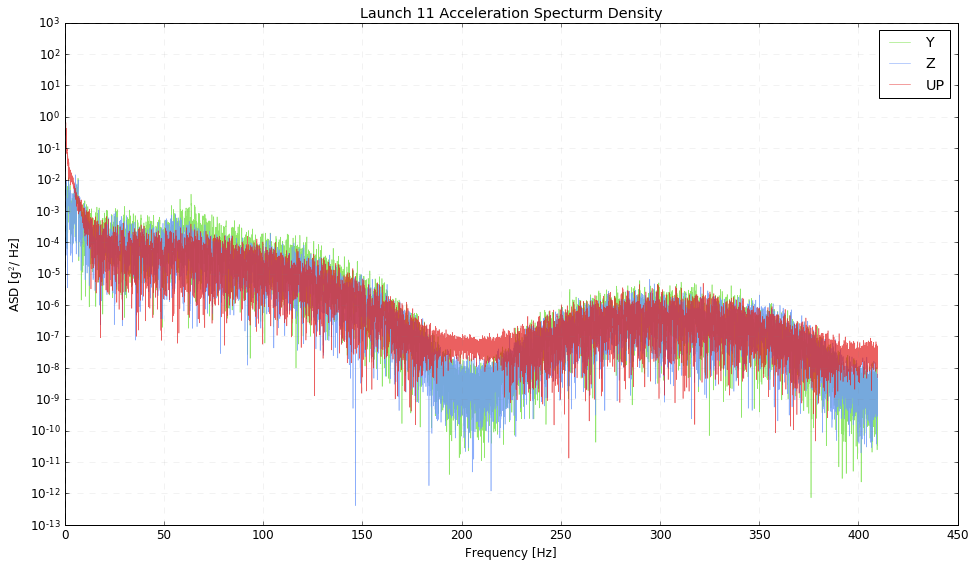

In [2]:
f, Pxx_den_x = periodogram(acc_x[2000:28000], 819.2, scaling='density')
f, Pxx_den_y = periodogram(acc_y[2000:28000], 819.2, scaling='density')
f, Pxx_den_z = periodogram(acc_z[2000:28000], 819.2, scaling='density')
fig = utils.Plot("Launch 11 Acceleration Specturm Density", "Frequency [Hz]", r"ASD [g$^2$/ Hz]")
fig.plot(f[1:], Pxx_den_y[1:], color=utils.green, log=True, label="Y")
fig.plot(f[1:], Pxx_den_z[1:], color=utils.blue, log=True, label="Z")
fig.plot(f[1:], Pxx_den_x[1:], alpha=0.7, log=True, label="UP")
fig.legend()
fig.show()

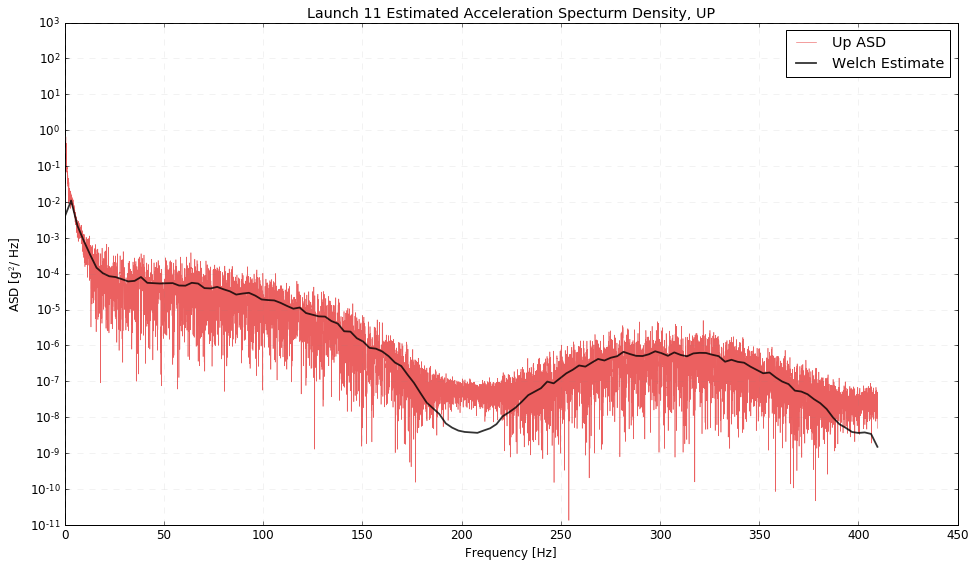

In [3]:
f_w, Pxx_den_w_x = welch(acc_x[2000:28000], 819.2, scaling='density')
fig = utils.Plot("Launch 11 Estimated Acceleration Specturm Density, UP", "Frequency [Hz]", r"ASD [g$^2$/ Hz]")
fig.plot(f[1:], Pxx_den_x[1:], alpha=0.7, log=True, label="Up ASD")
fig.plot(f_w, Pxx_den_w_x, color='black', lw=1.8, log=True, label="Welch Estimate")
fig.legend()
fig.show()

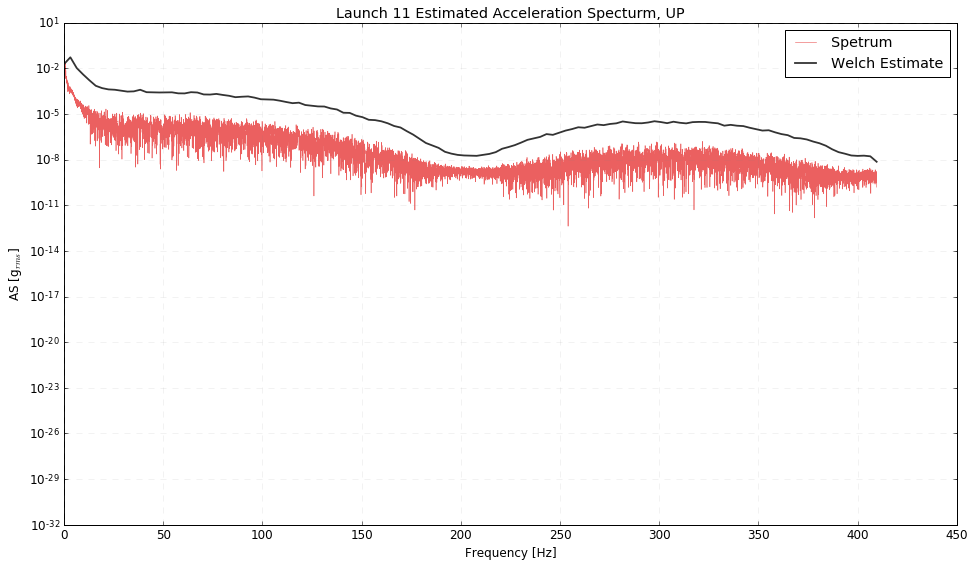

In [4]:
f, Pxx_den_s_x = periodogram(acc_x[2000:28000], 819.2, scaling='spectrum')
f_w, Pxx_den_sw_x = welch(acc_x[2000:28000], 819.2, scaling='spectrum')
fig = utils.Plot("Launch 11 Estimated Acceleration Specturm, UP", "Frequency [Hz]", r"AS [g$_{rms}$]")
fig.plot(f, Pxx_den_s_x, alpha=0.7, log=True, label="Spetrum")
fig.plot(f_w, Pxx_den_sw_x, color='black', lw=1.8, log=True, label="Welch Estimate")
fig.legend()
fig.show()

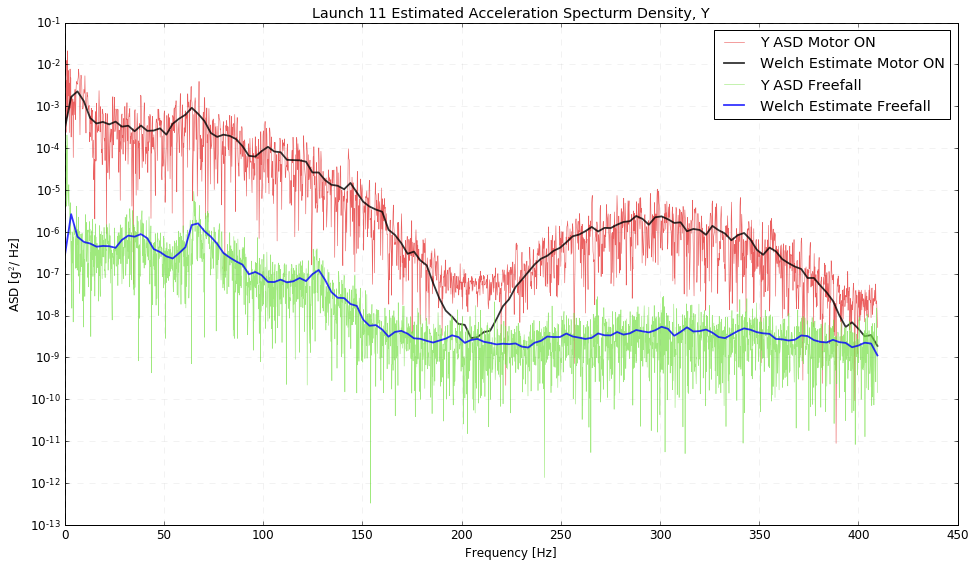

In [5]:
f, Pxx_den_y_motor    = periodogram(acc_y[2000:6600], 819.2, scaling='density')
f_w, Pxx_den_w_y_motor      = welch(acc_y[2000:6600], 819.2, scaling='density')

f_st, Pxx_den_y_still = periodogram(acc_y[21000:27000], 819.2, scaling='density')
f_w_st, Pxx_den_w_y_still   = welch(acc_y[21000:27000], 819.2, scaling='density')


fig = utils.Plot("Launch 11 Estimated Acceleration Specturm Density, Y", "Frequency [Hz]", r"ASD [g$^2$/ Hz]")
fig.plot(f[1:], Pxx_den_y_motor[1:], alpha=0.7, log=True, label="Y ASD Motor ON")
fig.plot(f_w, Pxx_den_w_y_motor, color='black', lw=1.8, log=True, label="Welch Estimate Motor ON")

fig.plot(f_st[1:], Pxx_den_y_still[1:], color=utils.green, alpha=0.7, log=True, label="Y ASD Freefall")
fig.plot(f_w_st, Pxx_den_w_y_still, color='blue', lw=1.8, log=True, label="Welch Estimate Freefall")

#fig.xlim([0, 200])
fig.legend()
fig.show()

## Vibration Over Time

We can make a waterfall plot of the vibration as it changes over time.

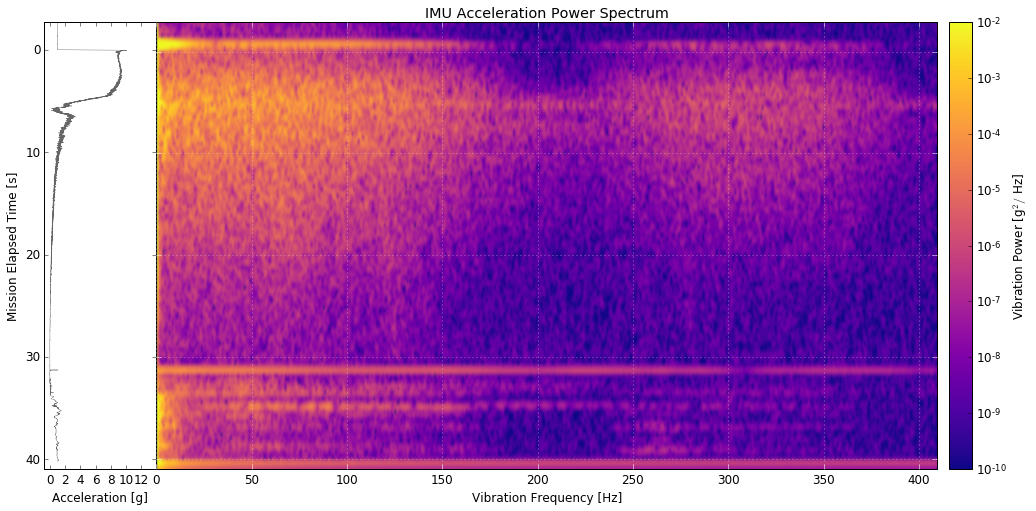

In [6]:
from math import sqrt
from scipy import signal
from matplotlib.colors import LogNorm
from scipy.interpolate import interp1d
from matplotlib import cm
import numpy as np
from matplotlib import gridspec
import matplotlib.pyplot as plt

accel = []
time = time[0:35000]

for i, t in enumerate(time):
    accel.append(sqrt((acc_x[i]*acc_x[i]) + (acc_y[i]*acc_y[i]) + (acc_z[i]*acc_z[i])))

fs = 819.2
data = accel
fft_size = 1024
overlap_fac = 0.75

hop_size = np.int32(np.floor(fft_size * (1-overlap_fac)))
pad_end_size = fft_size          # the last segment can overlap the end of the data array by no more than one window size
total_segments = np.int32(np.ceil(len(data) / np.float32(hop_size)))
t_max = len(data) / np.float32(fs)

window = np.hanning(fft_size)  # our half cosine window
inner_pad = np.zeros(fft_size) # the zeros which will be used to double each segment size

proc = np.concatenate((data, np.zeros(pad_end_size)))      # the data to process
result = np.empty((total_segments, 513), dtype=np.float32) # space to hold the result

for i in xrange(total_segments):
    current_hop = hop_size * i                        # figure out the current segment offset
    segment = proc[current_hop:current_hop+fft_size]  # get the current segment
    windowed = segment * window                       # multiply by the half cosine function
    f, pxx    = signal.periodogram(windowed, fs)      # scipi spectrum function on windowed segment
    result[i, :] = pxx


# Start Figure
fig = plt.figure(figsize=(16,8))
plt.subplots_adjust(wspace=0.001)   # no space between horizontal charts
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 7]) # stretch main chart to be most of the width

# Plot raw accel guide-chart
ax1 = plt.subplot(gs[0])
plt.title(r"")
plt.ylabel(r"Mission Elapsed Time [s]")
plt.xlabel(r"Acceleration [g]")
ax1.plot(data, time, 'k-', alpha=0.6, lw=0.4)
plt.xlim([-0.7,13.9])
plt.ylim([time[-1]+0.75,time[0]])

# Plot spetrogram
ax2 = plt.subplot(gs[1])
plt.title(r"IMU Acceleration Power Spectrum")
plt.xlabel(r"Vibration Frequency [Hz]")
img = ax2.imshow(result, origin='upper', cmap='plasma', interpolation='bicubic', aspect='auto', norm=LogNorm(vmax=1.0e-2, vmin=1.0e-10))

# Set sane ticks
tics = range(0,401,50)
ytics = range(0,41,10)
timebase = interp1d([time[0],time[-1]+1],[0,total_segments])
plt.xticks([t*(513/(fs/2.0)) for t in tics], tics)
plt.yticks([timebase(t) for t in ytics], ytics)

# Colors and grid
ax2.tick_params(axis='x', colors='white', labelcolor='black', length=5)
ax2.tick_params(axis='y', colors='white', labelcolor='black', length=5)
ax2.grid(color='#ffffff', alpha=0.8)
ticklabels = ax2.get_yticklabels()
plt.setp(ticklabels, visible=False)
plt.xlim([0,513])

# Colorbar tight placement
cbaxes = fig.add_axes([0.91, 0.125, 0.02, 0.775]) 
cbar = plt.colorbar(img, cax = cbaxes)
cbar.ax.set_ylabel(r'Vibration Power [g${}^2 /$ Hz]')

plt.show()